In [2]:
pip install torch torchvision torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 1.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
a

# Imports and Setup

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchattacks import PGD, FGSM
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data Preparation

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#  Model

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [29]:
torch.save(model.state_dict(), 'teacher_model.pth')

# Adversarial Attack Functions

## Fast Gradient Sign Method (FGSM) Attack

In [30]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().requires_grad_(True)
    with torch.enable_grad():
        outputs = model(images)
        model.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        images = images + epsilon * images.grad.sign()
        images = torch.clamp(images, min=0, max=1)
    return images

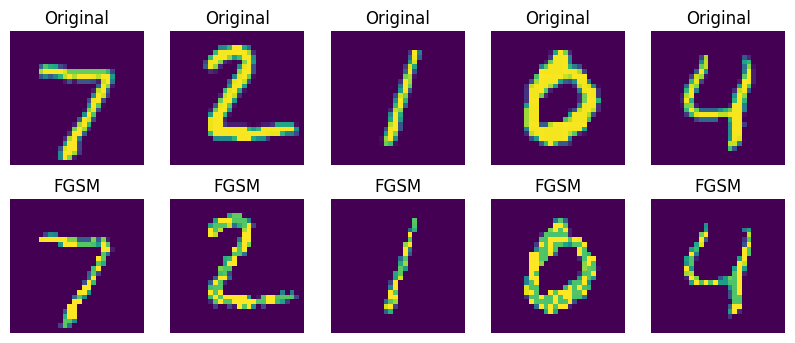

In [31]:
def plot_images(original, adversarial, n=5):
    original = original.cpu().detach()
    adversarial = adversarial.cpu().detach()
    plt.figure(figsize=(10, 4))  
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].permute(1, 2, 0) * 0.5 + 0.5)  
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(adversarial[i].permute(1, 2, 0) * 0.5 + 0.5)  
        plt.title("FGSM")
        plt.axis('off')
    plt.show()

epsilon = 0.25
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
perturbed_data = fgsm_attack(model, data, target, epsilon)
plot_images(data, perturbed_data)

## Projected Gradient Descent (PGD) Attack

In [32]:
def pgd_attack(model, images, labels, epsilon, alpha, num_steps):
    original_images = images.clone()
    images = images.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        with torch.enable_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()

            images = images + alpha * images.grad.sign()
            images = torch.where(images > original_images + epsilon, original_images + epsilon, images)
            images = torch.where(images < original_images - epsilon, original_images - epsilon, images)
            images = torch.clamp(images, 0, 1)

        images = images.detach().requires_grad_(True)

    return images

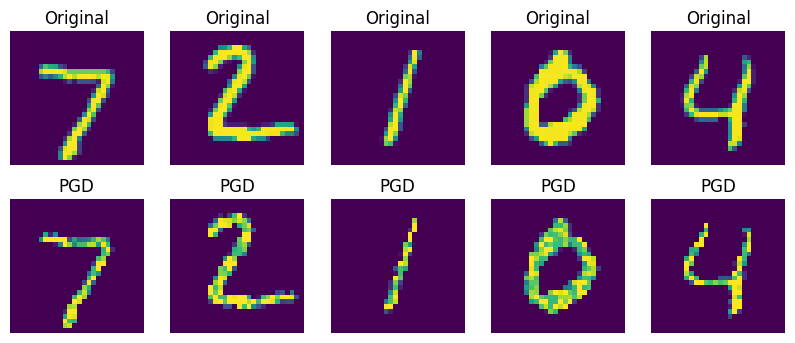

In [33]:
def plot_images(original, adversarial, n=5):
    original = original.cpu().detach()
    adversarial = adversarial.cpu().detach()
    plt.figure(figsize=(10, 4))  
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].permute(1, 2, 0) * 0.5 + 0.5)  
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(adversarial[i].permute(1, 2, 0) * 0.5 + 0.5)  
        plt.title("PGD")
        plt.axis('off')
    plt.show()
epsilon = 0.3  
alpha = 0.01   
num_steps = 40
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
perturbed_data = pgd_attack(model, data, target, epsilon, alpha, num_steps)
plot_images(data, perturbed_data)

## Basic Iterative Method (BIM) Attack

In [34]:
def bim_attack(model, images, labels, epsilon, alpha, num_iters):
    images = images.clone().detach().requires_grad_(True)
    original_images = images.clone().detach()

    for _ in range(num_iters):
        with torch.enable_grad():
            outputs = model(images)
            model.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            images = images + alpha * images.grad.sign()
           
            eta = torch.clamp(images - original_images, min=-epsilon, max=epsilon)
            images = torch.clamp(original_images + eta, min=0, max=1).detach_()
            images.requires_grad_(True)

    return images

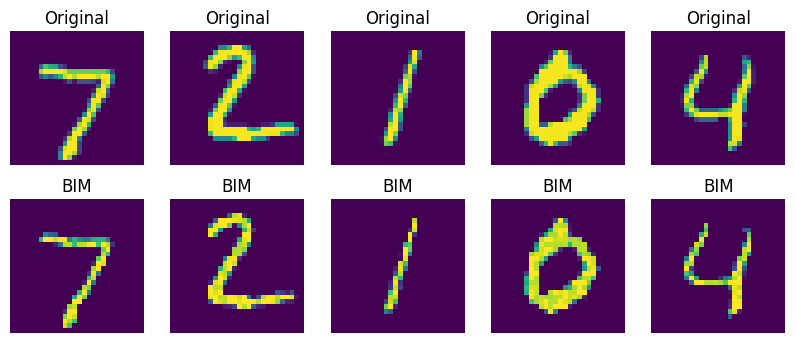

In [35]:
def plot_images(original, adversarial, n=5):
    original = original.cpu().detach()
    adversarial = adversarial.cpu().detach()
    plt.figure(figsize=(10, 4))  
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].permute(1, 2, 0) * 0.5 + 0.5)  
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(adversarial[i].permute(1, 2, 0) * 0.5 + 0.5)  
        plt.title("BIM")
        plt.axis('off')
    plt.show()

data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)

epsilon = 0.3  
alpha = 0.01   
num_iters = 10 

perturbed_data = bim_attack(model, data, target, epsilon, alpha, num_iters)

plot_images(data, perturbed_data)


## DeepFool Attack

In [36]:
def deepfool_attack(model, images, num_classes=10, overshoot=0.02, max_iter=50):
    images = images.clone().detach().to(device)
    batch_size = images.size(0)
    labels = model(images).argmax(dim=1)
    labels = labels.detach().cpu()

    adv_images = images.clone().detach()
    for idx in range(batch_size):
        image = adv_images[idx:idx+1].clone().detach().requires_grad_(True)
        output = model(image)
        _, current = output.data.max(1)

        if current.item() != labels[idx]:
            continue

        w = torch.zeros_like(image.data)
        r_tot = torch.zeros_like(image.data)

        loop_i = 0
        while loop_i < max_iter and current == labels[idx]:
            pert = None
            min_val = float('inf')

            outputs = model(image)
            grad_orig = torch.autograd.grad(outputs[0, current], image, retain_graph=True, create_graph=True)[0]
            image.grad = None  

            for k in range(num_classes):
                if k == current:
                    continue

                outputs_k = model(image)
                grad_k = torch.autograd.grad(outputs_k[0, k], image, retain_graph=True, create_graph=True)[0]
                image.grad = None  
                
                w_k = grad_k - grad_orig
                f_k = (outputs_k[0, k] - outputs_k[0, current]).data

                norm_w_k = torch.norm(w_k)
                
                val_k = abs(f_k) / norm_w_k

                if val_k < min_val:
                    min_val = val_k
                    pert = w_k / norm_w_k

            r_i = (pert * min_val).detach()
            r_tot = r_tot + r_i

            image = image + (1 + overshoot) * r_tot
            image = torch.clamp(image, 0, 1)
            image.requires_grad_(True)

            outputs = model(image)
            _, current = outputs.data.max(1)
            loop_i += 1

        adv_images[idx] = image.detach()

    return adv_images

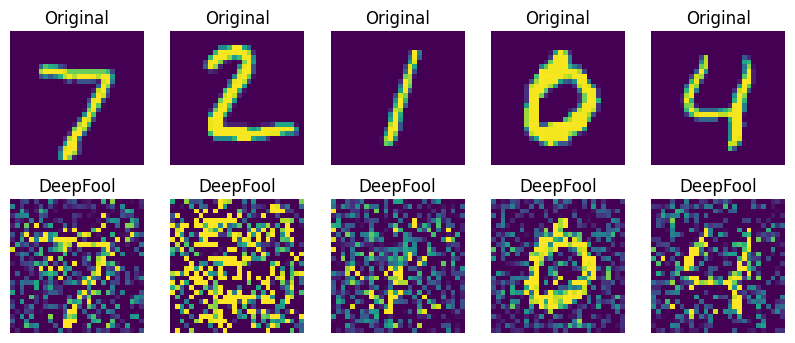

In [39]:
def plot_images(original, adversarial, n=5):
    original = original.cpu().detach()
    adversarial = adversarial.cpu().detach()
    plt.figure(figsize=(10, 4))  
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].permute(1, 2, 0) * 0.5 + 0.5)  
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(adversarial[i].permute(1, 2, 0) * 0.5 + 0.5)  
        plt.title("DeepFool")
        plt.axis('off')
    plt.show()

data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
adv_images = deepfool_attack(model, data)
plot_images(data, adv_images)

# Defensive Distillation

## StudentNet Class Definition

In [89]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Distillation Loss Function

In [90]:
def distillation_loss(student_output, teacher_output, target, T=3.0, alpha=0.7):

    ce_loss = criterion(student_output, target)

    student_log_softmax = F.log_softmax(student_output / T, dim=1)
    teacher_softmax = F.softmax(teacher_output / T, dim=1)
    kl_div = F.kl_div(student_log_softmax, teacher_softmax, reduction='batchmean') * T * T

    distillation_loss = alpha * ce_loss + (1 - alpha) * kl_div

    return distillation_loss

## Student Model Training Function

In [91]:
def train_student(student_model, device, train_loader, optimizer, epoch, teacher_model):
    student_model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:2d}")
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            teacher_output = teacher_model(data)

        optimizer.zero_grad()
        student_output = student_model(data)
        loss = distillation_loss(student_output, teacher_output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss / (batch_idx + 1))

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [92]:
student_model = StudentNet().to(device)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)

teacher_model = Net().to(device)
teacher_model.load_state_dict(torch.load('teacher_model.pth'))

num_epochs = 10
for epoch in range(num_epochs):
    student_loss = train_student(student_model, device, train_loader, student_optimizer, epoch, teacher_model)
    print(f"Epoch {epoch+1}/{num_epochs}: Student Loss={student_loss:.4f}")

Epoch  1: 100%|██████████| 938/938 [00:16<00:00, 55.20it/s, loss=0.987]


Epoch 1/10: Student Loss=0.9869


Epoch  2: 100%|██████████| 938/938 [00:17<00:00, 54.54it/s, loss=0.428]


Epoch 2/10: Student Loss=0.4283


Epoch  3: 100%|██████████| 938/938 [00:17<00:00, 54.77it/s, loss=0.362]


Epoch 3/10: Student Loss=0.3619


Epoch  4: 100%|██████████| 938/938 [00:17<00:00, 54.88it/s, loss=0.326]


Epoch 4/10: Student Loss=0.3259


Epoch  5: 100%|██████████| 938/938 [00:17<00:00, 54.77it/s, loss=0.299]


Epoch 5/10: Student Loss=0.2986


Epoch  6: 100%|██████████| 938/938 [00:17<00:00, 54.98it/s, loss=0.282]


Epoch 6/10: Student Loss=0.2822


Epoch  7: 100%|██████████| 938/938 [00:17<00:00, 55.10it/s, loss=0.266]


Epoch 7/10: Student Loss=0.2655


Epoch  8: 100%|██████████| 938/938 [00:16<00:00, 55.57it/s, loss=0.256]


Epoch 8/10: Student Loss=0.2562


Epoch  9: 100%|██████████| 938/938 [00:17<00:00, 54.67it/s, loss=0.241]


Epoch 9/10: Student Loss=0.2412


Epoch 10: 100%|██████████| 938/938 [00:16<00:00, 55.26it/s, loss=0.23] 

Epoch 10/10: Student Loss=0.2304


## Testing Function

In [93]:
def test(model, device, test_loader, attack=None, epsilon=None, alpha=None, num_steps=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            if attack == 'fgsm' and epsilon is not None:
                data = fgsm_attack(model, data, target, epsilon)
            elif attack == 'pgd' and epsilon is not None and alpha is not None and num_steps is not None:
                data = pgd_attack(model, data, target, epsilon, alpha, num_steps)
            elif attack == 'bim' and epsilon is not None and alpha is not None and num_steps is not None:
                data = bim_attack(model, data, target, epsilon, alpha, num_steps)
            elif attack == 'deepfool':
                data = deepfool_attack(model, data)

            output = model(data)
            test_loss += criterion(output, target).item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= total
    accuracy = 100. * correct / total
    print(f'Test set: Attack Type={attack}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')

    return test_loss, accuracy

In [94]:
_, clean_accuracy = test(student_model, device, test_loader)

_, fgsm_accuracy = test(student_model, device, test_loader, attack='fgsm', epsilon=0.25)

_, pgd_accuracy = test(student_model, device, test_loader, attack='pgd', epsilon=0.3, alpha=0.01, num_steps=40)

_, bim_accuracy = test(student_model, device, test_loader, attack='bim')

Test set: Attack Type=None, Average loss: 0.0014, Accuracy: 9765/10000 (97.65%)
Test set: Attack Type=fgsm, Average loss: 0.0264, Accuracy: 7122/10000 (71.22%)
Test set: Attack Type=pgd, Average loss: 0.0901, Accuracy: 2932/10000 (29.32%)
Test set: Attack Type=bim, Average loss: 0.0014, Accuracy: 9765/10000 (97.65%)


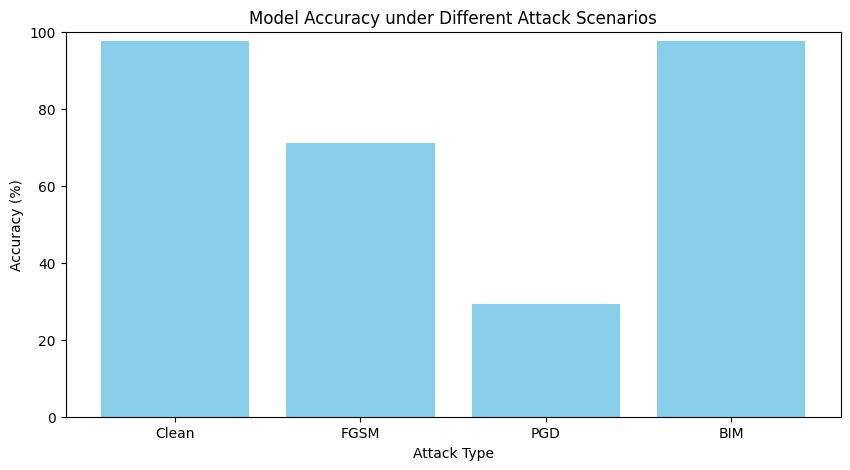

In [95]:
attacks = ['Clean', 'FGSM', 'PGD', 'BIM']
accuracies = [clean_accuracy, fgsm_accuracy, pgd_accuracy, bim_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(attacks, accuracies, color='skyblue')
plt.xlabel('Attack Type')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy under Different Attack Scenarios')
plt.ylim([0, 100])
plt.show()

# Adversarial Training

## Training Function

In [96]:
def adv_train(model, device, train_loader, optimizer, epoch, attack, epsilon=None, alpha=None, num_steps=None):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:2d}")
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        if attack == 'fgsm':
            data_adv = fgsm_attack(model, data, target, epsilon)
        elif attack == 'pgd':
            data_adv = pgd_attack(model, data, target, epsilon, alpha, num_steps)
        elif attack == 'bim':
            data_adv = bim_attack(model, data, target, epsilon, alpha, num_steps)
        elif attack == 'deepfool':
            data_adv = deepfool_attack(model, data)
        else:
            raise ValueError(f"Unsupported attack type: {attack}")

        optimizer.zero_grad()
        loss = criterion(model(data_adv), target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss / (batch_idx + 1))
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

## Testing Function

In [97]:
def test(model, device, test_loader, attack=None, epsilon=None, alpha=None, num_steps=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            if attack == 'fgsm':
                data = fgsm_attack(model, data, target, epsilon)
            elif attack == 'pgd':
                data = pgd_attack(model, data, target, epsilon, alpha, num_steps)
            elif attack == 'bim':
                data = bim_attack(model, data, target, epsilon, alpha, num_steps)
            elif attack == 'deepfool':
                data = deepfool_attack(model, data)  # No target parameter needed
            
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return test_loss  

In [98]:
num_epochs = 10
epsilon = 0.3  
alpha = 0.01  
num_steps = 40 

fgsm_losses = []
pgd_losses = []
bim_losses = []
clean_losses = []

for epoch in range(num_epochs):
    bim_loss = adv_train(model, device, train_loader, optimizer, epoch, 'bim', epsilon=epsilon, alpha=alpha, num_steps=num_steps)
    fgsm_loss = adv_train(model, device, train_loader, optimizer, epoch, 'fgsm', epsilon=epsilon)
    pgd_loss = adv_train(model, device, train_loader, optimizer, epoch, 'pgd', epsilon=epsilon, alpha=alpha, num_steps=num_steps)
    
    fgsm_losses.append(fgsm_loss)
    pgd_losses.append(pgd_loss)
    bim_losses.append(bim_loss)

    clean_loss = test(model, device, test_loader) 
    clean_losses.append(clean_loss)

    test(model, device, test_loader, 'fgsm', epsilon=epsilon)
    test(model, device, test_loader, 'pgd', epsilon=epsilon, alpha=alpha, num_steps=num_steps)
    test(model, device, test_loader, 'bim', epsilon=epsilon, alpha=alpha, num_steps=num_steps)

    print(f"Epoch {epoch+1}/{num_epochs}: FGSM Loss={fgsm_loss:.4f}, PGD Loss={pgd_loss:.4f}, BIM Loss={bim_loss:.4f}, Clean Loss={clean_loss:.4f}")

Epoch  1: 100%|██████████| 938/938 [01:21<00:00, 11.44it/s, loss=0.232]


Test set: Average loss: 0.0433, Accuracy: 8403/10000 (84.03%)
Test set: Average loss: 0.0015, Accuracy: 9675/10000 (96.75%)
Test set: Average loss: 0.0031, Accuracy: 9347/10000 (93.47%)
Test set: Average loss: 0.0031, Accuracy: 9347/10000 (93.47%)
Epoch 1/10: FGSM Loss=0.1270, PGD Loss=0.2318, BIM Loss=0.5767, Clean Loss=0.0433


Epoch  2: 100%|██████████| 938/938 [01:22<00:00, 11.38it/s, loss=0.156]


Test set: Average loss: 0.0234, Accuracy: 9034/10000 (90.34%)
Test set: Average loss: 0.0010, Accuracy: 9784/10000 (97.84%)
Test set: Average loss: 0.0024, Accuracy: 9501/10000 (95.01%)
Test set: Average loss: 0.0024, Accuracy: 9502/10000 (95.02%)
Epoch 2/10: FGSM Loss=0.0612, PGD Loss=0.1559, BIM Loss=0.1799, Clean Loss=0.0234


Epoch  3: 100%|██████████| 938/938 [01:22<00:00, 11.38it/s, loss=0.129]


Test set: Average loss: 0.0449, Accuracy: 8790/10000 (87.90%)
Test set: Average loss: 0.0010, Accuracy: 9776/10000 (97.76%)
Test set: Average loss: 0.0023, Accuracy: 9526/10000 (95.26%)
Test set: Average loss: 0.0023, Accuracy: 9526/10000 (95.26%)
Epoch 3/10: FGSM Loss=0.0419, PGD Loss=0.1288, BIM Loss=0.1336, Clean Loss=0.0449


Epoch  4: 100%|██████████| 938/938 [01:22<00:00, 11.40it/s, loss=0.112]


Test set: Average loss: 0.0241, Accuracy: 9102/10000 (91.02%)
Test set: Average loss: 0.0009, Accuracy: 9796/10000 (97.96%)
Test set: Average loss: 0.0021, Accuracy: 9557/10000 (95.57%)
Test set: Average loss: 0.0021, Accuracy: 9556/10000 (95.56%)
Epoch 4/10: FGSM Loss=0.0318, PGD Loss=0.1118, BIM Loss=0.1114, Clean Loss=0.0241


Epoch  5: 100%|██████████| 938/938 [01:22<00:00, 11.40it/s, loss=0.0996]


Test set: Average loss: 0.0355, Accuracy: 8789/10000 (87.89%)
Test set: Average loss: 0.0008, Accuracy: 9822/10000 (98.22%)
Test set: Average loss: 0.0021, Accuracy: 9577/10000 (95.77%)
Test set: Average loss: 0.0021, Accuracy: 9577/10000 (95.77%)
Epoch 5/10: FGSM Loss=0.0258, PGD Loss=0.0996, BIM Loss=0.0980, Clean Loss=0.0355


Epoch  6: 100%|██████████| 938/938 [01:22<00:00, 11.42it/s, loss=0.0912]


Test set: Average loss: 0.0232, Accuracy: 9168/10000 (91.68%)
Test set: Average loss: 0.0008, Accuracy: 9845/10000 (98.45%)
Test set: Average loss: 0.0020, Accuracy: 9596/10000 (95.96%)
Test set: Average loss: 0.0020, Accuracy: 9596/10000 (95.96%)
Epoch 6/10: FGSM Loss=0.0214, PGD Loss=0.0912, BIM Loss=0.0851, Clean Loss=0.0232


Epoch  7: 100%|██████████| 938/938 [01:22<00:00, 11.40it/s, loss=0.0806]


Test set: Average loss: 0.0166, Accuracy: 9456/10000 (94.56%)
Test set: Average loss: 0.0008, Accuracy: 9839/10000 (98.39%)
Test set: Average loss: 0.0022, Accuracy: 9581/10000 (95.81%)
Test set: Average loss: 0.0022, Accuracy: 9581/10000 (95.81%)
Epoch 7/10: FGSM Loss=0.0169, PGD Loss=0.0806, BIM Loss=0.0754, Clean Loss=0.0166


Epoch  8: 100%|██████████| 938/938 [01:21<00:00, 11.45it/s, loss=0.076] 


Test set: Average loss: 0.0370, Accuracy: 9020/10000 (90.20%)
Test set: Average loss: 0.0008, Accuracy: 9846/10000 (98.46%)
Test set: Average loss: 0.0023, Accuracy: 9605/10000 (96.05%)
Test set: Average loss: 0.0023, Accuracy: 9605/10000 (96.05%)
Epoch 8/10: FGSM Loss=0.0139, PGD Loss=0.0760, BIM Loss=0.0674, Clean Loss=0.0370


Epoch  9: 100%|██████████| 938/938 [01:22<00:00, 11.41it/s, loss=0.0685]


Test set: Average loss: 0.0303, Accuracy: 9165/10000 (91.65%)
Test set: Average loss: 0.0008, Accuracy: 9854/10000 (98.54%)
Test set: Average loss: 0.0023, Accuracy: 9574/10000 (95.74%)
Test set: Average loss: 0.0023, Accuracy: 9575/10000 (95.75%)
Epoch 9/10: FGSM Loss=0.0111, PGD Loss=0.0685, BIM Loss=0.0621, Clean Loss=0.0303


Epoch 10: 100%|██████████| 938/938 [01:22<00:00, 11.36it/s, loss=0.0649]


Test set: Average loss: 0.0331, Accuracy: 9244/10000 (92.44%)
Test set: Average loss: 0.0009, Accuracy: 9837/10000 (98.37%)
Test set: Average loss: 0.0025, Accuracy: 9568/10000 (95.68%)
Test set: Average loss: 0.0025, Accuracy: 9568/10000 (95.68%)
Epoch 10/10: FGSM Loss=0.0097, PGD Loss=0.0649, BIM Loss=0.0551, Clean Loss=0.0331


In [99]:
torch.save(model.state_dict(), 'teacher_model.pth')

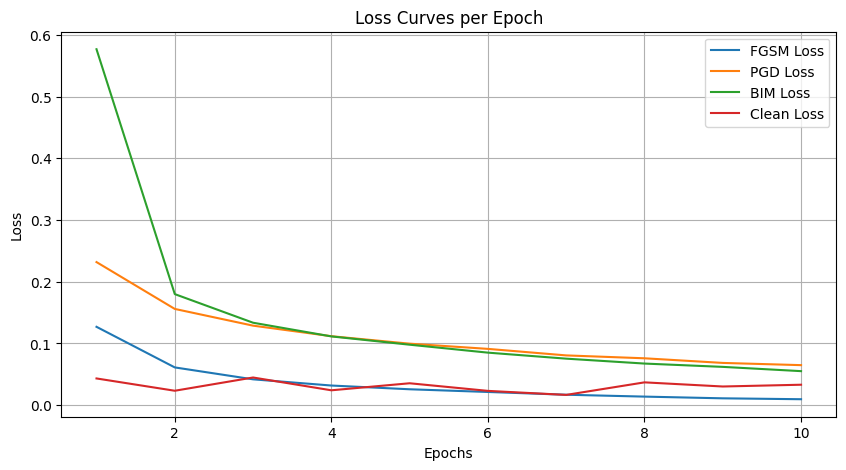

In [100]:
def plot_loss_curves(fgsm_losses, pgd_losses, deepfool_losses, clean_losses):
    epochs = range(1, len(fgsm_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, fgsm_losses, label='FGSM Loss')
    plt.plot(epochs, pgd_losses, label='PGD Loss')
    plt.plot(epochs, bim_losses, label='BIM Loss')
    plt.plot(epochs, clean_losses, label='Clean Loss')
    plt.title('Loss Curves per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(fgsm_losses, pgd_losses, bim_losses, clean_losses)

In [101]:
def test(model, device, test_loader, attack=None, epsilon=None, alpha=None, num_steps=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            if attack == 'fgsm' and epsilon is not None:
                data = fgsm_attack(model, data, target, epsilon)
            elif attack == 'pgd' and epsilon is not None and alpha is not None and num_steps is not None:
                data = pgd_attack(model, data, target, epsilon, alpha, num_steps)
            elif attack == 'bim' and epsilon is not None and alpha is not None and num_steps is not None:
                data = bim_attack(model, data, target, epsilon, alpha, num_steps)
            elif attack == 'deepfool':
                data = deepfool_attack(model, data)

            output = model(data)
            test_loss += criterion(output, target).item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= total
    accuracy = 100. * correct / total
    print(f'Test set: Attack Type={attack}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')

    return test_loss, accuracy


In [102]:
_, clean_accuracy = test(model, device, test_loader)

_, fgsm_accuracy = test(model, device, test_loader, attack='fgsm', epsilon=0.25)

_, pgd_accuracy = test(model, device, test_loader, attack='pgd', epsilon=0.3, alpha=0.01, num_steps=40)

_, bim_accuracy = test(model, device, test_loader, attack='bim', epsilon=0.3, alpha=0.01, num_steps=40)


Test set: Attack Type=None, Average loss: 0.0331, Accuracy: 9244/10000 (92.44%)
Test set: Attack Type=fgsm, Average loss: 0.0008, Accuracy: 9855/10000 (98.55%)
Test set: Attack Type=pgd, Average loss: 0.0025, Accuracy: 9568/10000 (95.68%)
Test set: Attack Type=bim, Average loss: 0.0025, Accuracy: 9568/10000 (95.68%)


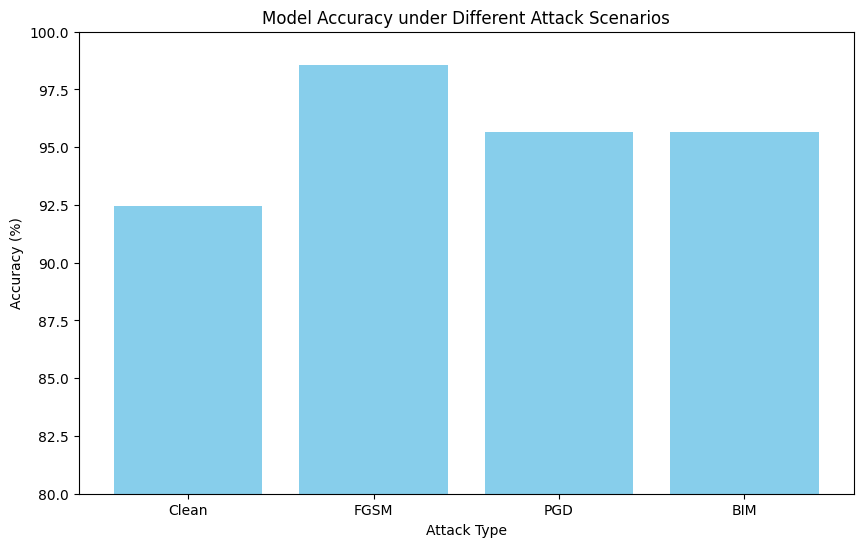

In [114]:
attacks = ['Clean', 'FGSM', 'PGD', 'BIM']
accuracies = [92.44, 98.55, 95.68, 95.68]  # These values are from your previous print statements.

plt.figure(figsize=(10, 6))
plt.bar(attacks, accuracies, color='skyblue')
plt.xlabel('Attack Type')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy under Different Attack Scenarios')
plt.ylim(80, 100)  
plt.show()


# Adversarial Logit Pairing (ALP)

## Adversarial Logit Pairing (ALP) loss

In [104]:
def alp_loss(model, images, labels, epsilon, alpha, num_steps):
    clean_logits = model(images)
    adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_steps)
    adv_logits = model(adv_images)
    alp_reg_loss = F.mse_loss(clean_logits, adv_logits)
    return alp_reg_loss

In [105]:
def adv_train(model, device, train_loader, optimizer, epoch, attack, epsilon=None, alpha=None, num_steps=None, alp_weight=0.1):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:2d}")
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        if attack == 'fgsm':
            data_adv = fgsm_attack(model, data, target, epsilon)
        elif attack == 'pgd':
            data_adv = pgd_attack(model, data, target, epsilon, alpha, num_steps)
        elif attack == 'bim':
            data_adv = bim_attack(model, data, target, epsilon, alpha, num_steps)
        elif attack == 'deepfool':
            data_adv = deepfool_attack(model, data)
        else:
            raise ValueError(f"Unsupported attack type: {attack}")

        optimizer.zero_grad()
        loss = criterion(model(data_adv), target)

        if attack == 'pgd' or attack == 'bim':
            if alpha is None or num_steps is None:
                alpha = 0.01  
                num_steps = 40  
            alp_reg_loss = alp_loss(model, data, target, epsilon, alpha, num_steps)
        else:
            alp_reg_loss = 0  

        total_loss = loss + alp_weight * alp_reg_loss

        total_loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=total_loss.item() / (batch_idx + 1)) 

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [106]:
def test(model, device, test_loader, attack=None, epsilon=None, alpha=None, num_steps=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            if attack == 'fgsm' and epsilon is not None:
                data = fgsm_attack(model, data, target, epsilon)
            elif attack == 'pgd' and epsilon is not None and alpha is not None and num_steps is not None:
                data = pgd_attack(model, data, target, epsilon, alpha, num_steps)
            elif attack == 'bim' and epsilon is not None and alpha is not None and num_steps is not None:
                data = bim_attack(model, data, target, epsilon, alpha, num_steps)
            elif attack == 'deepfool':
                data = deepfool_attack(model, data)

            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Attack Type={attack}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')
    return test_loss, accuracy

In [107]:
num_epochs = 10
epsilon = 0.3
alpha = 0.01
num_steps = 40
alp_weight = 0.1  

fgsm_losses = []
pgd_losses = []
bim_losses = []
clean_losses = []

for epoch in range(num_epochs):
    bim_loss = adv_train(model, device, train_loader, optimizer, epoch, 'bim', epsilon=epsilon, alpha=alpha, num_steps=num_steps, alp_weight=alp_weight)
    fgsm_loss = adv_train(model, device, train_loader, optimizer, epoch, 'fgsm', epsilon=epsilon, alp_weight=alp_weight)
    pgd_loss = adv_train(model, device, train_loader, optimizer, epoch, 'pgd', epsilon=epsilon, alpha=alpha, num_steps=num_steps, alp_weight=alp_weight)

    fgsm_losses.append(fgsm_loss)
    pgd_losses.append(pgd_loss)
    bim_losses.append(bim_loss)

    clean_loss, clean_accuracy = test(model, device, test_loader)
    clean_losses.append(clean_loss)

    test(model, device, test_loader, 'fgsm', epsilon=epsilon)
    test(model, device, test_loader, 'pgd', epsilon=epsilon, alpha=alpha, num_steps=num_steps)
    test(model, device, test_loader, 'bim', epsilon=epsilon, alpha=alpha, num_steps=num_steps)

    print(f"Epoch {epoch+1}/{num_epochs}: FGSM Loss={fgsm_loss:.4f}, PGD Loss={pgd_loss:.4f}, BIM Loss={bim_loss:.4f}, Clean Loss={clean_loss:.4f}")

Epoch  1: 100%|██████████| 938/938 [02:30<00:00,  6.24it/s, loss=0.000224]


Test set: Attack Type=None, Average loss: 0.0058, Accuracy: 8971/10000 (89.71%)
Test set: Attack Type=fgsm, Average loss: 0.0009, Accuracy: 9849/10000 (98.49%)
Test set: Attack Type=pgd, Average loss: 0.0025, Accuracy: 9541/10000 (95.41%)
Test set: Attack Type=bim, Average loss: 0.0025, Accuracy: 9541/10000 (95.41%)
Epoch 1/10: FGSM Loss=0.0000, PGD Loss=0.0002, BIM Loss=0.0005, Clean Loss=0.0058


Epoch  2: 100%|██████████| 938/938 [02:30<00:00,  6.24it/s, loss=0.000186]


Test set: Attack Type=None, Average loss: 0.0029, Accuracy: 9468/10000 (94.68%)
Test set: Attack Type=fgsm, Average loss: 0.0008, Accuracy: 9856/10000 (98.56%)
Test set: Attack Type=pgd, Average loss: 0.0021, Accuracy: 9600/10000 (96.00%)
Test set: Attack Type=bim, Average loss: 0.0021, Accuracy: 9600/10000 (96.00%)
Epoch 2/10: FGSM Loss=0.0000, PGD Loss=0.0002, BIM Loss=0.0002, Clean Loss=0.0029


Epoch  3: 100%|██████████| 938/938 [02:30<00:00,  6.24it/s, loss=0.000213]


Test set: Attack Type=None, Average loss: 0.0020, Accuracy: 9635/10000 (96.35%)
Test set: Attack Type=fgsm, Average loss: 0.0008, Accuracy: 9845/10000 (98.45%)
Test set: Attack Type=pgd, Average loss: 0.0020, Accuracy: 9600/10000 (96.00%)
Test set: Attack Type=bim, Average loss: 0.0020, Accuracy: 9598/10000 (95.98%)
Epoch 3/10: FGSM Loss=0.0000, PGD Loss=0.0002, BIM Loss=0.0002, Clean Loss=0.0020


Epoch  4: 100%|██████████| 938/938 [02:29<00:00,  6.26it/s, loss=0.000113]


Test set: Attack Type=None, Average loss: 0.0012, Accuracy: 9759/10000 (97.59%)
Test set: Attack Type=fgsm, Average loss: 0.0008, Accuracy: 9846/10000 (98.46%)
Test set: Attack Type=pgd, Average loss: 0.0020, Accuracy: 9615/10000 (96.15%)
Test set: Attack Type=bim, Average loss: 0.0020, Accuracy: 9615/10000 (96.15%)
Epoch 4/10: FGSM Loss=0.0000, PGD Loss=0.0001, BIM Loss=0.0001, Clean Loss=0.0012


Epoch  5: 100%|██████████| 938/938 [02:30<00:00,  6.25it/s, loss=3.63e-5] 


Test set: Attack Type=None, Average loss: 0.0010, Accuracy: 9816/10000 (98.16%)
Test set: Attack Type=fgsm, Average loss: 0.0008, Accuracy: 9851/10000 (98.51%)
Test set: Attack Type=pgd, Average loss: 0.0020, Accuracy: 9623/10000 (96.23%)
Test set: Attack Type=bim, Average loss: 0.0020, Accuracy: 9622/10000 (96.22%)
Epoch 5/10: FGSM Loss=0.0000, PGD Loss=0.0000, BIM Loss=0.0002, Clean Loss=0.0010


Epoch  6: 100%|██████████| 938/938 [02:29<00:00,  6.27it/s, loss=6.93e-5] 


Test set: Attack Type=None, Average loss: 0.0009, Accuracy: 9826/10000 (98.26%)
Test set: Attack Type=fgsm, Average loss: 0.0008, Accuracy: 9853/10000 (98.53%)
Test set: Attack Type=pgd, Average loss: 0.0020, Accuracy: 9634/10000 (96.34%)
Test set: Attack Type=bim, Average loss: 0.0020, Accuracy: 9634/10000 (96.34%)
Epoch 6/10: FGSM Loss=0.0000, PGD Loss=0.0001, BIM Loss=0.0001, Clean Loss=0.0009


Epoch  7: 100%|██████████| 938/938 [02:29<00:00,  6.28it/s, loss=5.35e-5] 


Test set: Attack Type=None, Average loss: 0.0010, Accuracy: 9819/10000 (98.19%)
Test set: Attack Type=fgsm, Average loss: 0.0008, Accuracy: 9845/10000 (98.45%)
Test set: Attack Type=pgd, Average loss: 0.0020, Accuracy: 9616/10000 (96.16%)
Test set: Attack Type=bim, Average loss: 0.0020, Accuracy: 9618/10000 (96.18%)
Epoch 7/10: FGSM Loss=0.0005, PGD Loss=0.0001, BIM Loss=0.0001, Clean Loss=0.0010


Epoch  8: 100%|██████████| 938/938 [02:29<00:00,  6.29it/s, loss=5.02e-5] 


Test set: Attack Type=None, Average loss: 0.0009, Accuracy: 9815/10000 (98.15%)
Test set: Attack Type=fgsm, Average loss: 0.0009, Accuracy: 9825/10000 (98.25%)
Test set: Attack Type=pgd, Average loss: 0.0023, Accuracy: 9587/10000 (95.87%)
Test set: Attack Type=bim, Average loss: 0.0023, Accuracy: 9588/10000 (95.88%)
Epoch 8/10: FGSM Loss=0.0000, PGD Loss=0.0001, BIM Loss=0.0000, Clean Loss=0.0009


Epoch  9: 100%|██████████| 938/938 [02:29<00:00,  6.28it/s, loss=0.000192]


Test set: Attack Type=None, Average loss: 0.0009, Accuracy: 9822/10000 (98.22%)
Test set: Attack Type=fgsm, Average loss: 0.0009, Accuracy: 9837/10000 (98.37%)
Test set: Attack Type=pgd, Average loss: 0.0023, Accuracy: 9586/10000 (95.86%)
Test set: Attack Type=bim, Average loss: 0.0023, Accuracy: 9586/10000 (95.86%)
Epoch 9/10: FGSM Loss=0.0000, PGD Loss=0.0002, BIM Loss=0.0001, Clean Loss=0.0009


Epoch 10: 100%|██████████| 938/938 [02:29<00:00,  6.28it/s, loss=0.000145]


Test set: Attack Type=None, Average loss: 0.0007, Accuracy: 9846/10000 (98.46%)
Test set: Attack Type=fgsm, Average loss: 0.0009, Accuracy: 9841/10000 (98.41%)
Test set: Attack Type=pgd, Average loss: 0.0023, Accuracy: 9595/10000 (95.95%)
Test set: Attack Type=bim, Average loss: 0.0023, Accuracy: 9595/10000 (95.95%)
Epoch 10/10: FGSM Loss=0.0000, PGD Loss=0.0001, BIM Loss=0.0001, Clean Loss=0.0007


In [108]:
clean_loss, clean_accuracy = test(model, device, test_loader)

fgsm_loss, fgsm_accuracy = test(model, device, test_loader, attack='fgsm', epsilon=0.25)

pgd_loss, pgd_accuracy = test(model, device, test_loader, attack='pgd', epsilon=0.3, alpha=0.01, num_steps=40)

bim_loss, bim_accuracy = test(model, device, test_loader, attack='bim', epsilon=0.3, alpha=0.01, num_steps=40)

print(f"Clean data: Loss = {clean_loss:.4f}, Accuracy = {clean_accuracy:.2f}%")
print(f"FGSM Attack: Loss = {fgsm_loss:.4f}, Accuracy = {fgsm_accuracy:.2f}%")
print(f"PGD Attack: Loss = {pgd_loss:.4f}, Accuracy = {pgd_accuracy:.2f}%")
print(f"BIM Attack: Loss = {bim_loss:.4f}, Accuracy = {bim_accuracy:.2f}%")

Test set: Attack Type=None, Average loss: 0.0007, Accuracy: 9846/10000 (98.46%)
Test set: Attack Type=fgsm, Average loss: 0.0007, Accuracy: 9862/10000 (98.62%)
Test set: Attack Type=pgd, Average loss: 0.0023, Accuracy: 9595/10000 (95.95%)
Test set: Attack Type=bim, Average loss: 0.0023, Accuracy: 9595/10000 (95.95%)
Clean data: Loss = 0.0007, Accuracy = 98.46%
FGSM Attack: Loss = 0.0007, Accuracy = 98.62%
PGD Attack: Loss = 0.0023, Accuracy = 95.95%
BIM Attack: Loss = 0.0023, Accuracy = 95.95%


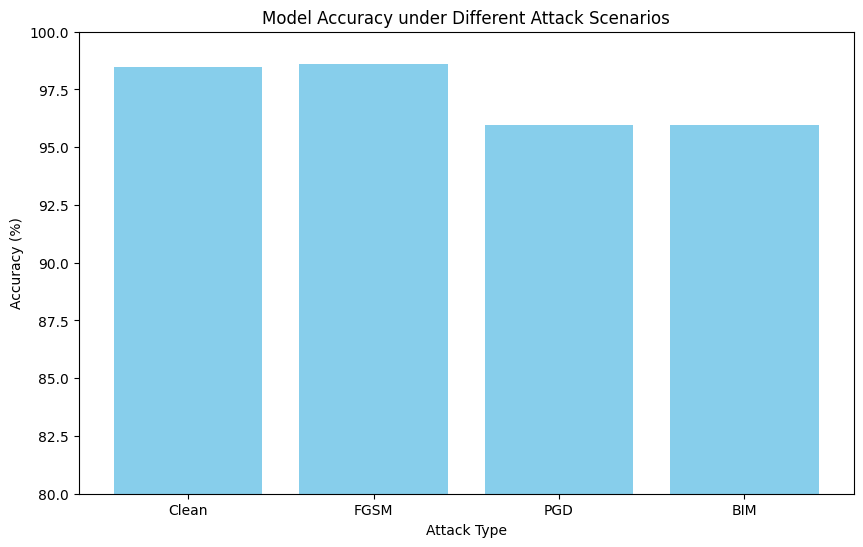

In [115]:
attacks = ['Clean', 'FGSM', 'PGD', 'BIM']
accuracies = [98.46, 98.62, 95.95, 95.95]  

plt.figure(figsize=(10, 6))
plt.bar(attacks, accuracies, color='skyblue')
plt.xlabel('Attack Type')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy under Different Attack Scenarios')
plt.ylim(80, 100) 
plt.show()
